## An Investigation in classifying Alumni’s College Regions using respective Salaries

## INTRODUCTION

Our data set takes many colleges, and groups them according to where they’re located by region. Along with the region, our data set has the starting median salary, along with the mid-career median salary which further aids classification. 

**Classification question: Given a person’ entry level and mid-career salary, which region did they most likely attend colleges in?**

The data set we are using from Where it pays to attend college is “Salaries for colleges by region”, collected from The Wall Street Journal, Payscale Inc. This data frame provides the average entry level salary and mid-career salary from colleges in the U.S., which are classified by the regions the colleges are located in. We intend to use K-nearest neighbors classification to examine the data set, whereby we predict new observations (colleges that are not within our data sets) into a region based on their entry and mid-career salary using K numbers of closest entry and mid-career salary in the set.



In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


## EXPLORATORY DATA ANALYSIS

In [2]:
download.file("https://raw.githubusercontent.com/colinyee9935/DSCI100_Group_Project/main/data/salaries_by_region.csv", "salary_region.csv")
salary_region<-read_csv("salary_region.csv")

salary_region <- salary_region |>
    rename_with(~str_to_lower(.) |>              #reformat the column names into lower case and replace space with underscores
                str_replace_all("[^[:alnum:]]+", "_"), .cols = everything())|>
    mutate(mid_career_10th_percentile_salary = na_if(mid_career_10th_percentile_salary, "N/A"))|>
    mutate(mid_career_90th_percentile_salary = na_if(mid_career_90th_percentile_salary, "N/A"))|>

#turning column to dbl
    mutate(mid_career_10th_percentile_salary_d=as.numeric(mid_career_10th_percentile_salary))|>
    mutate(mid_career_90th_percentile_salary_d=as.numeric(mid_career_90th_percentile_salary))|>
    select(-mid_career_10th_percentile_salary,-mid_career_90th_percentile_salary)|>

#rearranging columns
    select(1:4, mid_career_10th_percentile_salary_d, everything(), mid_career_90th_percentile_salary_d)|>
    rename(midc_10th_salary = mid_career_10th_percentile_salary_d,
          midc_25th_salary= mid_career_25th_percentile_salary,
          midc_75th_salary=mid_career_75th_percentile_salary,
          midc_90th_salary=mid_career_90th_percentile_salary_d)
    

#    select(school_name:mid_career_median_salary)
salary_region

Rows: 320 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): School Name, Region, Mid-Career 10th Percentile Salary, Mid-Career ...
dbl (4): Starting Median Salary, Mid-Career Median Salary, Mid-Career 25th P...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


school_name,region,starting_median_salary,mid_career_median_salary,midc_10th_salary,midc_25th_salary,midc_75th_salary,midc_90th_salary
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Stanford University,California,70400,129000,68400,93100,184000,257000
California Institute of Technology (CIT),California,75500,123000,NA,104000,161000,NA
Harvey Mudd College,California,71800,122000,NA,96000,180000,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
State University of New York (SUNY) at Fredonia,Northeastern,37800,66200,32800,44200,93300,181000
University of Southern Maine,Northeastern,39400,63600,40400,47900,85700,117000
Mercy College,Northeastern,43700,62600,35600,47300,99000,134000


## Visualizations

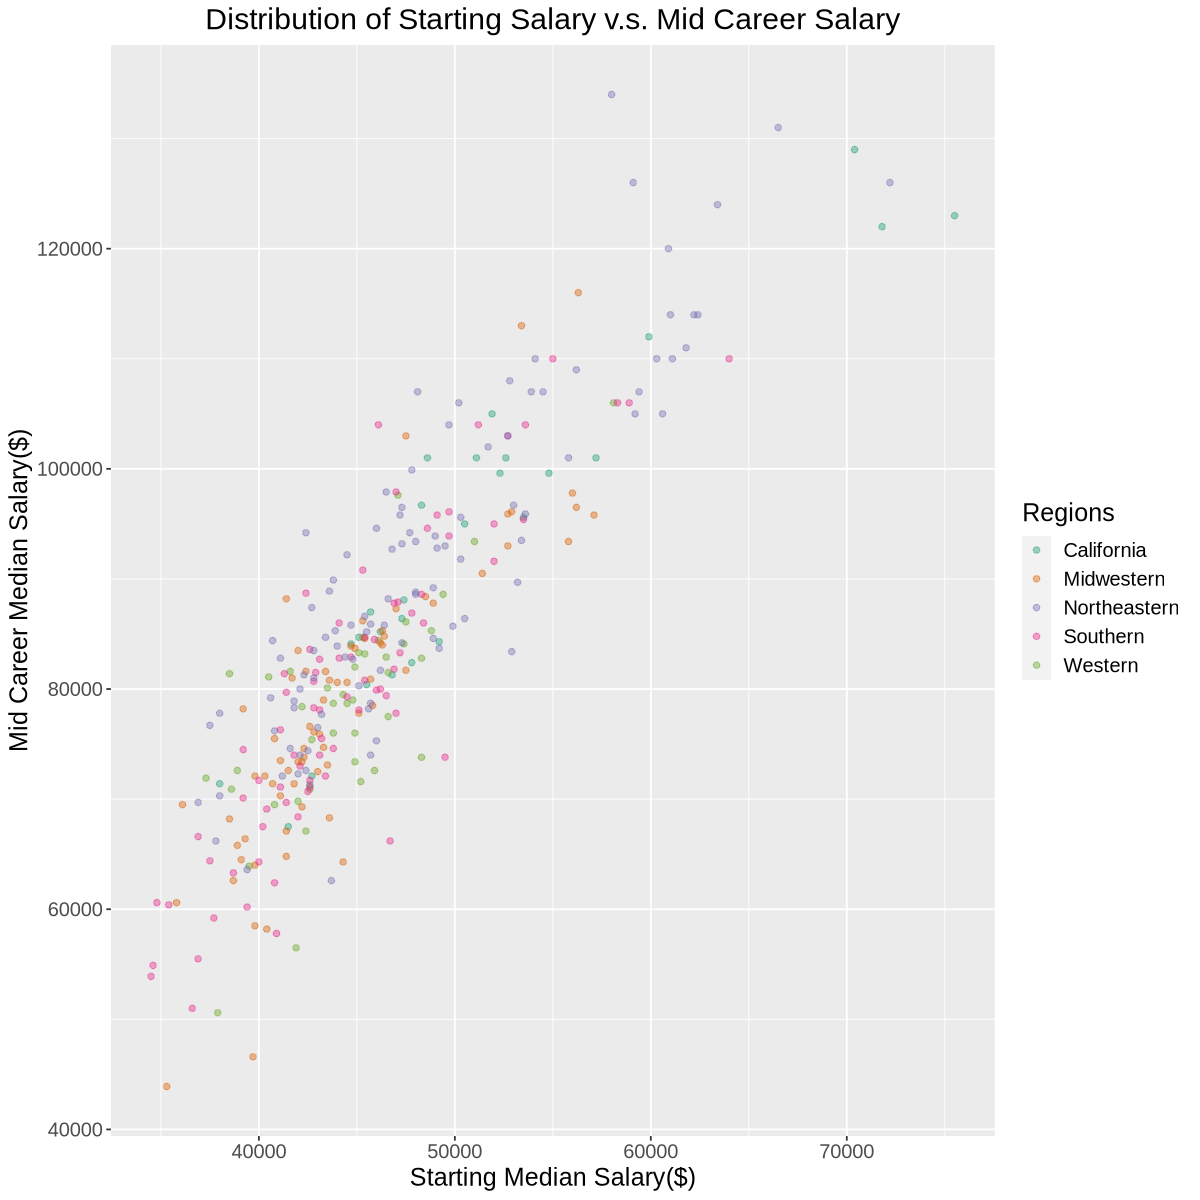

In [14]:
#graphing of data sets: starting median salary and mid career median salary
#distribution of the two definitive data we'll be using

options(repr.plot.width = 10, repr.plot.height = 10)

salary_region_graph<-salary_region|>
    ggplot(aes(x=starting_median_salary, y=mid_career_median_salary, color=region))+
    geom_point(alpha = 0.4)+
    labs(x="Starting Median Salary($)",
        y="Mid Career Median Salary($)",
        title = "Distribution of Starting Salary v.s. Mid Career Salary",
        color="Regions")+
    scale_color_brewer(palette = "Dark2")+
    theme(text=element_text(size=15), plot.title = element_text(hjust = 0.5))

salary_region_graph

# add tittle

#the distribution has some distinct characteristics to it - 
#a large group of data points are clustered in the box formulated by x(40000,50000) and y(70000,90000).
#Classification within this range might becomes obscure as data points affialited to each region is really close toghether
#We would want to incorporate other predictors in this case, this pattern can be found in the histograms below

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


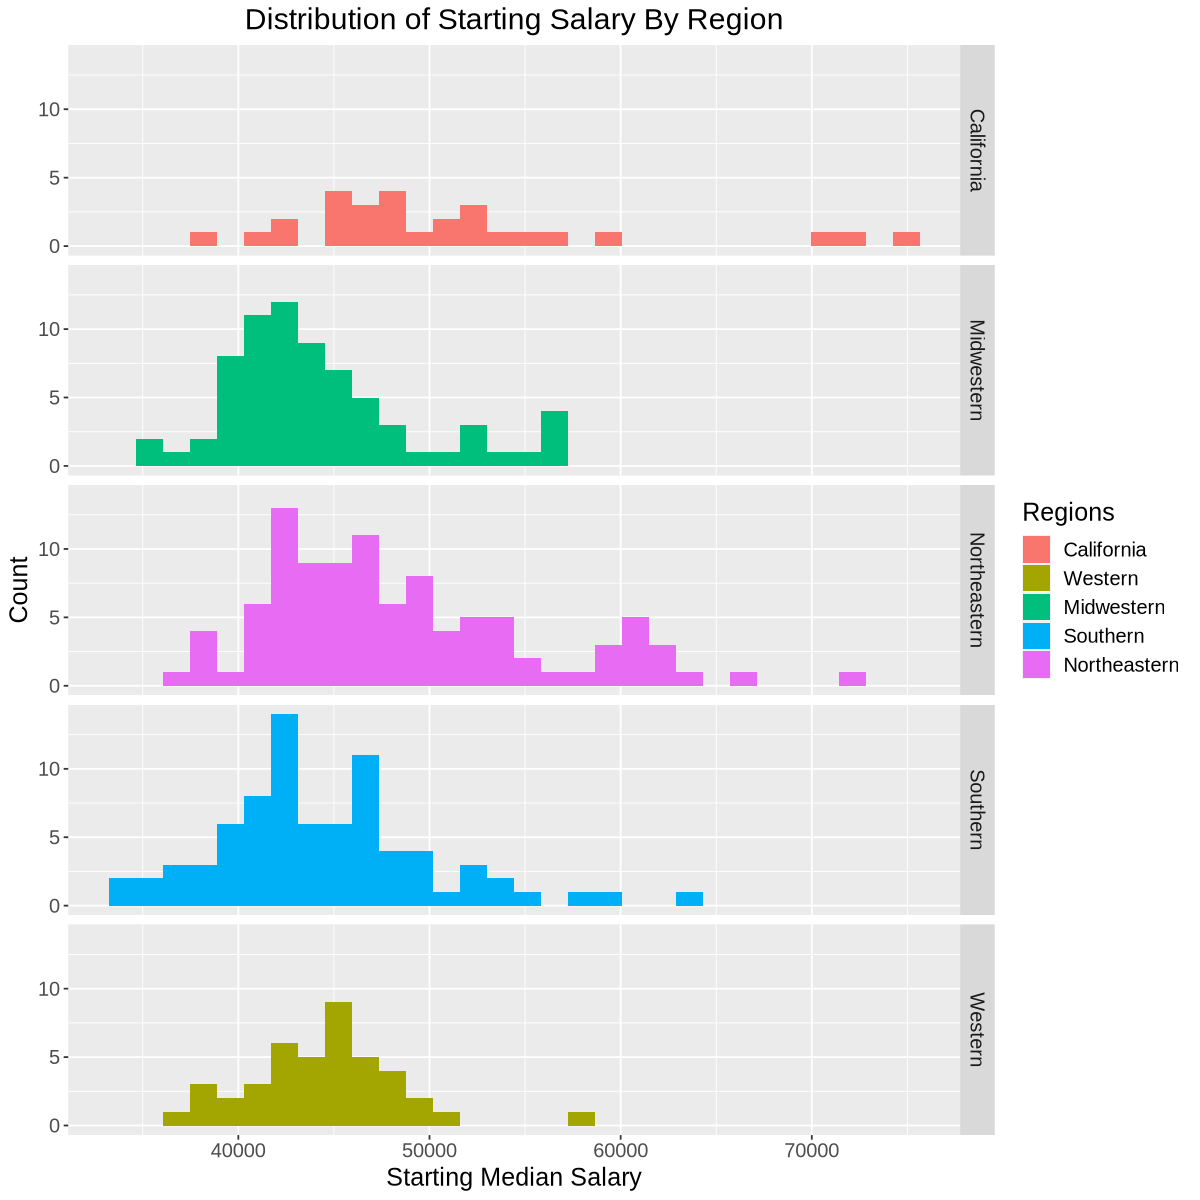

In [17]:
region_hist <- ggplot(salary_region, aes(x = starting_median_salary, fill = as_factor(region))) +
    geom_histogram() +
    facet_grid(rows = vars(region))+
    labs(x="Starting Median Salary",
    y="Count",
    title = "Distribution of Starting Salary By Region",
    fill="Regions")+
    theme(text=element_text(size=15), plot.title = element_text(hjust = 0.5))
region_hist

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


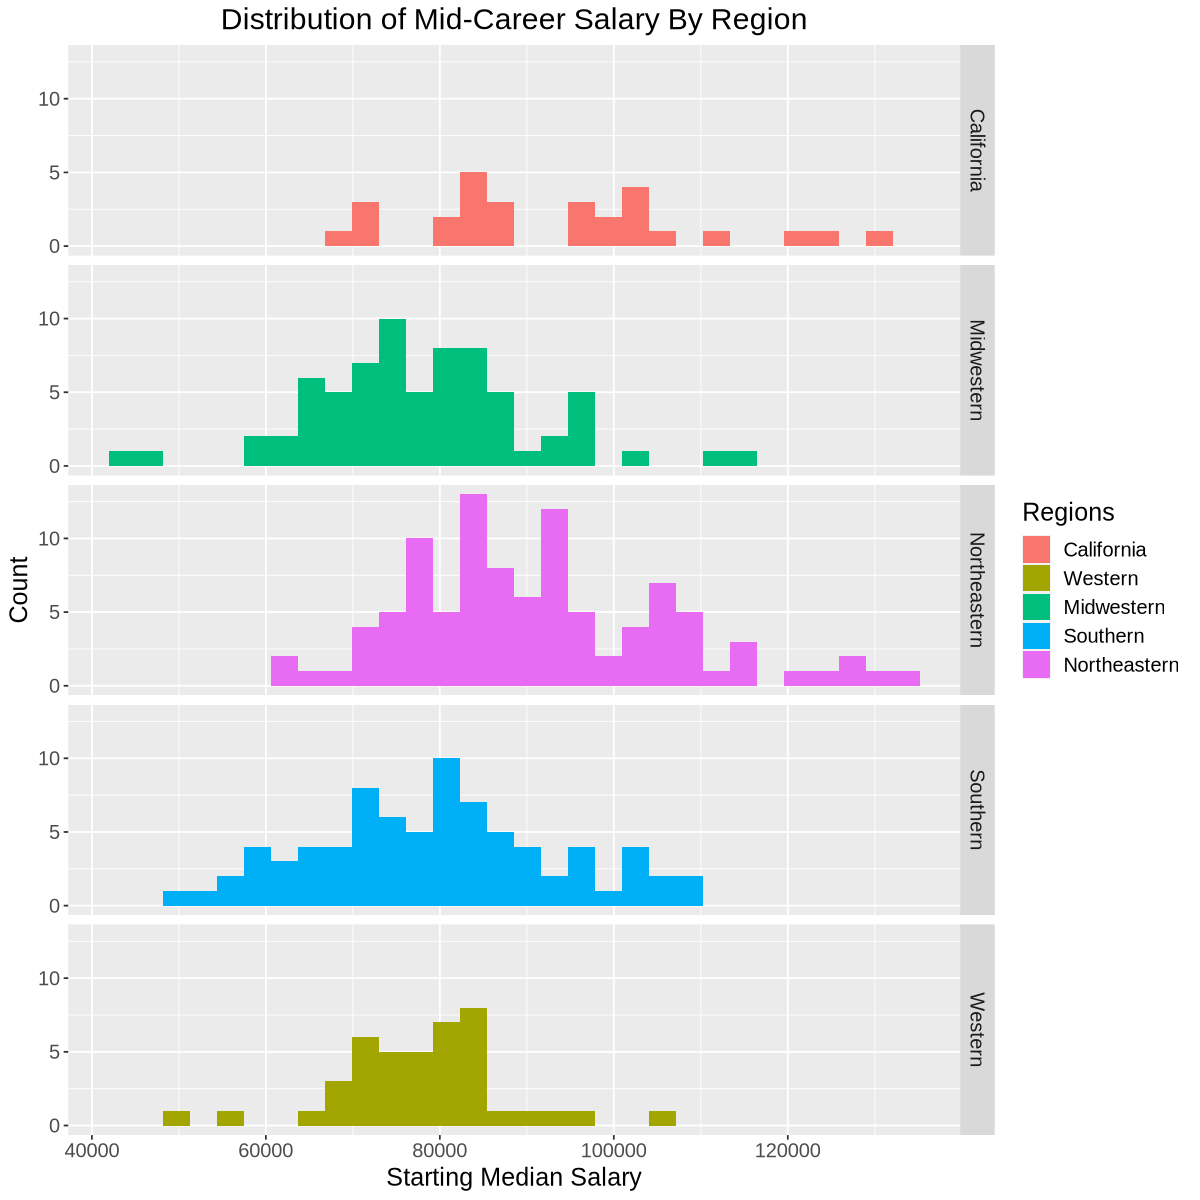

In [18]:
region_hist <- ggplot(salary_region, aes(x = mid_career_median_salary, fill = as_factor(region))) +
    geom_histogram() +
    facet_grid(rows = vars(region))+
    labs(x="Starting Median Salary",
    y="Count",
    title = "Distribution of Mid-Career Salary By Region",
    fill="Regions")+
    theme(text=element_text(size=15), plot.title = element_text(hjust = 0.5))
region_hist

Comments: from the two set of graphs above, we see regions California and Northeastern consistently have higher quartile of both type of salaries, while the other exhibits the opposite trend.

## Tables

In [4]:
#investigate the number of observations in each region
#this is important in finding whether each group has sufficient data points for reference

region_count<-salary_region|>
    group_by(region)|>
    summarize(count=n())
region_count

#from the table below, we can see that there are an unbalance observation between regions
#This is going to affect the model which ultimately impact the predications. We need to procede with caution and be critical on our findings.

region,count
<chr>,<int>
California,28
Midwestern,71
Northeastern,100
Southern,79
Western,42


In [5]:
#counting the missing data points in certain columnds of the data table
#this is signigicant in deciding whether we should incorporate percentile column in our classification model for increasing accuracy

columns_to_check <- c("midc_10th_salary", "midc_25th_salary", "midc_75th_salary", "midc_90th_salary")

missing_counts <- salary_region |>
    summarize(across(all_of(columns_to_check), ~ sum(is.na(.), na.rm = TRUE)))
missing_counts


#The following table shows the number of missing data in each percentile salary column.
#This is about 15% of the entire set with their respective column
#As for some regions that has lower number of observation, such as California
#The issue becomes prominent as they are weighed less if a data is missing when used
#Nonetheless, we could incorporate 25th and 75th percentile in addition to default predictors above

midc_10th_salary,midc_25th_salary,midc_75th_salary,midc_90th_salary
<int>,<int>,<int>,<int>
47,0,0,47


## METHODS

The three columns of data we will be using from the data set are region, starting median salary, mid-career salary. Region is going to be our factor in the analysis, and starting median salary, and mid career salary are going to be our predictors. The significance of starting median salary and mid career salary is the combination gives a more holistic view of alumni’s salary as people who graduated from the top colleges are likely to receive higher average salary at the start but for those who did not go to those colleges, they might start with lower average salary but eventually hit that bar. This creates a unique pattern of identification for the type of colleges, which is also impacted by the regions of the colleges (higher paying places vs. lower paying places) a person went to when performing the classification, allowing for higher accuracy during the test. As stated above, we will create a K-nearest neighbors classification model with the region as factor and the two salary types as the predictors. Before this, we’ll follow the conventions of subsetting our data set into 5 proportionate subset, each will be tested against the remaining 80% of the data for training of internal consistency, and yield the best possible K. We’ll then use this K value for classification of a newly observed data set provided in another sheet from the website.

### Visualization
We’ll be generating a confusion matrix that helps to visualize the number of correct predictions and false predictions. From here, we’re going to be able to assess the accuracy of the model in terms of its accuracy, precision, and recall by defining the positive object.


## EXPECTED OUTCOMES AND SIGNIFICANCE

### Expected Outcomes
We could find that some regions have a higher starting salary than other regions, so we can generalize and assume that a higher starting salary/middle salary would correlate to those specific regions 

### Impact of findings
We can use these findings as guidance strategies for educational investments and career guidance to enhance economic growth. Furthermore, providing students with region-specific salary data will allow them to make better-informed decisions about their education and take a proactive approach toward career planning for long-term success.

### Future question
Future research could explore the effects of industry distribution, local economies, and cost of living on regional salary outcomes for graduates.


